In [1]:
using Distributed

using Pkg


@everywhere begin 
    using ParallelTemperingMonteCarlo
    using DelimitedFiles
    using BenchmarkTools
end

In [2]:
using Random
@everywhere import ..MCRun: initialise_histograms!,updatehistogram!,update_max_stepsize!,sampling_step!,save_results,save_states
Random.seed!(1234)

# number of atoms
n_atoms = 13

# temperature grid
ti = 50.
tf = 160.
n_traj = 8

temp = TempGrid{n_traj}(ti,tf) 

# MC simulation details
mc_cycles = 400 #default 20% equilibration cycles on top
mc_sample = 1  #sample every mc_sample MC cycles

displ_atom = 0.1 # Angstrom
n_adjust = 100

max_displ_atom = [0.1*sqrt(displ_atom*temp.t_grid[i]) for i in 1:n_traj]

mc_params = MCParams(mc_cycles, n_traj, n_atoms, mc_sample = mc_sample, n_adjust = n_adjust, eq_percentage = 1)

#moves - allowed at present: atom, volume and rotation moves (volume,rotation not yet implemented)
move_strat = MoveStrategy(atom_moves = n_atoms)  

#ensemble
ensemble = NVT(n_atoms)
#icosahedral ground state of Ne13 (from Cambridge cluster database) in Angstrom
ico_13  = [[-0.0000000049,       -0.0000000044,       -0.0000000033],
[-0.0000007312,       -0.0000000014,        0.6554619119],
 [0.1811648930,      -0.5575692094,        0.2931316798],
[-0.4742970242,       -0.3445967289,        0.2931309525],
[-0.4742970303,        0.3445967144,        0.2931309494],
 [0.1811648830,        0.5575692066,        0.2931316748],
 [0.5862626299,        0.0000000022,        0.2931321262],
[-0.1811648928,       -0.5575692153,       -0.2931316813],
[-0.5862626397,       -0.0000000109,       -0.2931321327],
[-0.1811649028,        0.5575692007,       -0.2931316863],
 [0.4742970144,        0.3445967202,       -0.2931309590],
 [0.4742970205,       -0.3445967231,       -0.2931309559],
 [0.0000007214,       -0.0000000073,       -0.6554619185]]
 ico_55 = [[0.0000006584,       -0.0000019175,        0.0000000505],
 [-0.0000005810,       -0.0000004871,        0.6678432175],
 [0.1845874248,       -0.5681026047,        0.2986701538],
 [-0.4832557457,       -0.3511072166,        0.2986684497],
 [-0.4832557570,        0.3511046452,        0.2986669456],
 [0.1845874064,        0.5681000550,        0.2986677202],
 [0.5973371920,       -0.0000012681,        0.2986697030],
 [-0.1845860897,       -0.5681038901,       -0.2986676192],
 [-0.5973358752,       -0.0000025669,       -0.2986696020],
 [-0.1845861081,        0.5680987696,       -0.2986700528],
 [0.4832570624,        0.3511033815,       -0.2986683486],
 [0.4832570738,       -0.3511084803,       -0.2986668445],
 [0.0000018978,       -0.0000033480,       -0.6678431165],
 [-0.0000017969,        0.0000009162,        1.3230014650],
 [0.1871182835,       -0.5758942175,        0.9797717078],
 [-0.4898861924,       -0.3559221410,       0.9797699802],
 [-0.4898862039,        0.3559224872,        0.9797684555],
 [0.1871182648,        0.5758945856,        0.9797692407],
 [0.6055300485,        0.0000001908,        0.9797712507],
 [0.7926501864,       -0.5758950093,        0.6055339635],
 [0.3656681761,       -1.1254128670,        0.5916673591],
 [-0.3027660545,       -0.9318173412,        0.6055326929],
 [-0.9573332453,       -0.6955436707,        0.5916639831],
 [-0.9797705418,       -0.0000006364,        0.6055294407],
 [-0.9573332679,        0.6955423392,        0.5916610035],
 [-0.3027660847,        0.9318160902,        0.6055287012],
 [0.3656681396,        1.1254115783,        0.5916625380],
 [0.7926501677,        0.5758937939,        0.6055314964],
 [1.1833279992,       -0.0000006311,        0.5916664660],
 [0.6770051458,       -0.9318186223,        0.0000033028],
 [0.0000006771,       -1.1517907207,        0.0000025175],
 [-0.6770037988,       -0.9318186442,        0.0000007900],
 [-1.0954155825,       -0.3559242494,       -0.0000012200],
 [-1.0954155940,        0.3559203788,       -0.0000027447],
 [-0.6770038290,        0.9318147872,       -0.0000032017],
 [0.0000006397,        1.1517868856,       -0.0000024165],
 [0.6770051155,        0.9318148091,       -0.0000006889],
 [1.0954168993,        0.3559204143,        0.0000013211],
 [1.0954169108,       -0.3559242139,        0.0000028458],
 [0.3027674014,       -0.9318199253,       -0.6055286002],
 [-0.3656668229,       -1.1254154134,       -0.5916624370],
 [-0.7926488510,       -0.5758976290,       -0.6055313954],
 [-1.1833266824,       -0.0000032040,       -0.5916663649],
 [-0.7926488697,        0.5758911742,       -0.6055338624],
 [-0.3656668594,        1.1254090319,       -0.5916672580],
 [0.3027673712,        0.9318135061,       -0.6055325919],
 [0.9573345621,        0.6955398357,       -0.5916638820],
 [0.9797718586,       -0.0000031986,       -0.6055293396],
 [0.9573345846,       -0.6955461743,       -0.5916609025],
 [-0.1871169480,       -0.5758984207,       -0.9797691397],
 [-0.6055287318,       -0.0000040259,       -0.9797711497],
 [-0.1871169667,        0.5758903824,       -0.9797716067],
 [0.4898875091,        0.3559183059,       -0.9797698792],
 [0.4898875207,       -0.3559263223,       -0.9797683545],
 [0.0000031136,       -0.0000047513,       -1.3230013639]]
 #convert to Bohr
 nmtobohr = 18.8973
 copperconstant = 0.36258*nmtobohr
 pos_cu55 = copperconstant*ico_55
 pos_cu13 = copperconstant*ico_13*1.5
 AtoBohr = 1.8897259886
 
 # length(pos_cu55) == n_atoms || error("number of atoms and positions not the same - check starting config")
 
 #boundary conditions 
 bc_cu55 = SphericalBC(radius=14*AtoBohr)   #5.32 Angstrom
 bc_cu13 = SphericalBC(radius=8*AtoBohr)
 #starting configuration

#starting configuration
# start_config = Config(pos_cu13, bc_cu13)
start_config = Config(pos_cu55, bc_cu55)
 #histogram information
 n_bin = 100
 #en_min = -0.006    #might want to update after equilibration run if generated on the fly
 #en_max = -0.001    #otherwise will be determined after run as min/max of sampled energies (ham vector)



#histogram information
n_bin = 100



runnerdir = "/home/ghun245/RuNNer-testing/Brass_potential/"
atomtype="Cu"
pot = AbstractMLPotential(runnerdir,atomtype)
# RuNNer.getRuNNerenergy(runnerdir,1;input_idx=2)
pot_vector = []

for i =1:Threads.nthreads()
    potential=ParallelMLPotential(runnerdir,"Cu",i)
    push!(pot_vector,potential)
end
mc_states = [MCState(temp.t_grid[i], temp.beta_grid[i], start_config, pot_vector[1]; max_displ=[max_displ_atom[i],0.01,1.]) for i in 1:n_traj]

results = Output{Float64}(n_bin; en_min = mc_states[1].en_tot)

Output{Float64}(100, 0.0, 0.0, Float64[], Float64[], Float64[], Vector{Float64}[], Float64[], Float64[], Float64[], Float64[], Float64[])

In [ ]:
# function testparallelrunner(parallel_states,a,v,r,delta_en,n_threads,pot_vec)
#     Threads.@threads for i=1:4
#         for j=1:100
#             mc_cycle!(parallel_states[i], move_strat, mc_params, pot_vec[i], ensemble, 1, a, v, r)
#         end
#     end
# end

# function testrunner(parallel_states,a,v,r,delta_en,n_threads,pot_vec)
#     for i=1:4
#         for j=1:100
#             mc_cycle!(parallel_states[i], move_strat, mc_params, pot_vec[i], ensemble, 1, a, v, r)
#         end
#     end
# end
# function testparallelrunner2(parallel_states,a,v,r,delta_en,n_threads,pot_vec)
#     Threads.@threads for i=1:8
#         for j=1:10
#             mc_cycle!(parallel_states[i], move_strat, mc_params, pot_vec[i], ensemble, 1, a, v, r)
#         end
#     end
# end

# function testrunner2(parallel_states,a,v,r,delta_en,n_threads,pot_vec)
#     for i=1:8
#         for j=1:10
#             mc_cycle!(parallel_states[i], move_strat, mc_params, pot_vec[i], ensemble, 1, a, v, r)
#         end
#     end
# end

In [ ]:
parallel_states,pot_vec,a,v,r,delta_en,n_threads = parallel_equilibration(mc_states,move_strat,mc_params,pot_vector[1],ensemble,results)

In [ ]:
# @benchmark testrunner2(parallel_states,a,v,r,delta_en,n_threads,pot_vector)
# @benchmark testparallelrunner2(parallel_states,a,v,r,delta_en,n_threads,pot_vector)
# n_steps = 1

# @benchmark ParallelRun.pptmc_cycle(parallel_states,mc_params,results,move_strat,pot_vec,ensemble,n_threads,delta_en,n_steps,a,v,r)
@time ParallelRun.pptmc_run!(mc_states,move_strat,mc_params,pot,ensemble,results)

We've concluded initial tests confirming that this is -- in principle -- possible to utilise several threads to run PTMC in parallel, there remain questions as to whether it is as effective as standard, serial PTMC. We test this now with Neon

In [3]:
Random.seed!(1234)

# number of atoms
n_atoms = 13

# temperature grid
ti = 5.
tf = 16.
n_traj = 32

temp = TempGrid{n_traj}(ti,tf) 

# MC simulation details
mc_cycles = 1000000 #default 20% equilibration cycles on top
mc_sample = 1  #sample every mc_sample MC cycles

#move_atom=AtomMove(n_atoms) #move strategy (here only atom moves, n_atoms per MC cycle)
displ_atom = 0.1 # Angstrom
n_adjust = 100

max_displ_atom = [0.1*sqrt(displ_atom*temp.t_grid[i]) for i in 1:n_traj]

mc_params = MCParams(mc_cycles, n_traj, n_atoms, mc_sample = mc_sample, n_adjust = n_adjust)

#moves - allowed at present: atom, volume and rotation moves (volume,rotation not yet implemented)
move_strat = MoveStrategy(atom_moves = n_atoms)  

#ensemble
ensemble = NVT(n_atoms)

#ELJpotential for neon
#c1=[-10.5097942564988, 0., 989.725135614556, 0., -101383.865938807, 0., 3918846.12841668, 0., -56234083.4334278, 0., 288738837.441765]
#elj_ne1 = ELJPotential{11}(c1)

c=[-10.5097942564988, 989.725135614556, -101383.865938807, 3918846.12841668, -56234083.4334278, 288738837.441765]
pot = ELJPotentialEven{6}(c)

#starting configurations
#icosahedral ground state of Ne13 (from Cambridge cluster database) in Angstrom
pos_ne13 = [[2.825384495892464, 0.928562467914040, 0.505520149314310],
[2.023342172678102,	-2.136126268595355, 0.666071287554958],
[2.033761811732818,	-0.643989413759464, -2.133000349161121],
[0.979777205108572,	2.312002562803556, -1.671909307631893],
[0.962914279874254,	-0.102326586625353, 2.857083360096907],
[0.317957619634043,	2.646768968413408, 1.412132053672896],
[-2.825388342924982, -0.928563755928189, -0.505520471387560],
[-0.317955944853142, -2.646769840660271, -1.412131825293682],
[-0.979776174195320, -2.312003751825495, 1.671909138648006],
[-0.962916072888105, 0.102326392265998,	-2.857083272537599],
[-2.023340541398004, 2.136128558801072,	-0.666071089291685],
[-2.033762834001679, 0.643989905095452, 2.132999911364582],
[0.000002325340981,	0.000000762100600, 0.000000414930733]]

#convert to Bohr
AtoBohr = 1.8897259886
pos_ne13 = pos_ne13 * AtoBohr

length(pos_ne13) == n_atoms || error("number of atoms and positions not the same - check starting config")

#boundary conditions 
bc_ne13 = SphericalBC(radius=5.32*AtoBohr)   #5.32 Angstrom

#starting configuration
start_config = Config(pos_ne13, bc_ne13)

#histogram information
n_bin = 100
#en_min = -0.006    #might want to update after equilibration run if generated on the fly
#en_max = -0.001    #otherwise will be determined after run as min/max of sampled energies (ham vector)

#construct array of MCState (for each temperature)
mc_states = [MCState(temp.t_grid[i], temp.beta_grid[i], start_config, pot; max_displ=[max_displ_atom[i],0.01,1.]) for i in 1:n_traj]

#results = Output(n_bin, max_displ_vec)
results = Output{Float64}(n_bin; en_min = mc_states[1].en_tot)

Output{Float64}(100, 0.0, 0.0, Float64[], Float64[], Float64[], Vector{Float64}[], Float64[], Float64[], Float64[], Float64[], Float64[])

In [15]:
@time ParallelRun.pptmc_run!(mc_states,move_strat,mc_params,pot,ensemble,results)

In [11]:
cd("/home/ghun245/ParallelTemperingMonteCarlo.jl/scripts/")
multihistogram(results,temp)

InterruptException: InterruptException:

In [12]:
using DelimitedFiles
analysisfile = open("analysis.NVT","r")
analysis = readdlm(analysisfile)
close(analysisfile)
using Plots

plot(analysis[2:end,1],analysis[2:end,3])

SystemError: SystemError: opening file "analysis.NVT": No such file or directory

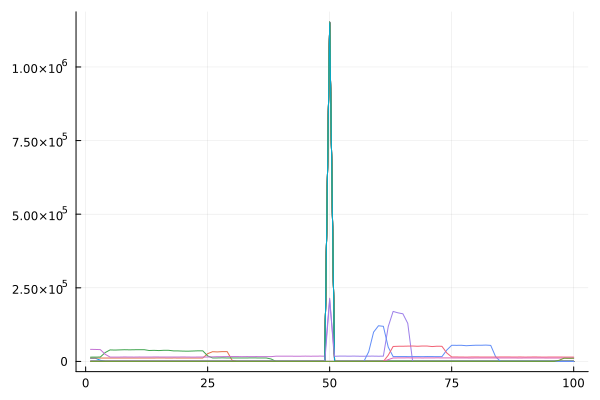

In [13]:
data = [results.en_histogram[i][2:end-1] for i in 1:n_traj]
plot(data, legend=false)
